# Ablations Experiment for Model params (d_model) study

In this notebook, we created and trained a transformer model based on our ablation experiment setup, specifically to observe the effects of changes in the no. of token embeddings (d_model) of the model. The architecture is defined as per the 'experiment_model.py' file, and we utilise functions created in the 'experiment_utils.py' file to facilitate the training process.

The flow of this notebook is similar to that of the baseline model, but with modifications to accommodate the ablation study requirements. The loss values are recorded for upcoming analysis, visualization and cross comparison.

In [1]:
import matplotlib.pyplot as plt
import optax
import sys
import jax
import time
import os
import numpy as np
from pathlib import Path

cwd = Path.cwd()

# Project root for local setup
project_root = cwd.parents[0]

from ablations.experiment_setup import experiment_utils as fn

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


# Load the Experiment Setup

## Set the relevant directory paths & update.log file

Here, we set the necessary directories and output paths for saving model checkpoints and training logs.

In [2]:
# Data directory paths
local_dir = project_root / "data" / "text8_train.txt"
online_dir = project_root / "text8_train.txt"

if local_dir.exists():
    data_dir = str(local_dir) # This is for local runs or if repository is cloned directly
else:
    data_dir = "." + str(online_dir) # This is for online GPU platforms

config_path = cwd / "config.json"
training_log_file = cwd / "training_results.log"
validation_log_file = cwd / "validation_results.log"
checkpoint_file = cwd / "checkpoint.pkl"

In [3]:
if not os.path.exists(training_log_file):
    fn.initialize_training_log(training_log_file)

if not os.path.exists(validation_log_file):
    fn.initialize_validation_log(validation_log_file)

[initialize_training_log] Initialized training log file at /content/training_results.log
[initialize_validation_log] Initialized validation log file at /content/validation_results.log


## Load the experiment configurations

Prior to running this notebook, the experiment configurations will be set in a 'config.json' file, which will be loaded to set the model hyperparameters and training settings.

In [4]:
config = fn.load_config("./config.json")

print(f"We will be conducting {config['description']}.")

[load_config] Loaded configuration from ./config.json
We will be conducting Ablation test for d_model set to 512.


In [5]:
# Load the seed
seed = config['seed']

# Model parameters
vocab_size = config['model']['vocab_size']
d_model = config['model']['d_model']
n_heads = config['model']['n_heads']
n_layers = config['model']['n_layers']
mlp_ratio = config['model']['mlp_ratio']
seq_len = config['model']['seq_len']

# Training parameters
loss_type = config['model']['loss_type']
dropout_rate = config['model']['dropout']
weight_decay = config['model']['weight_decay']
label_smoothing = config['model']['label_smoothing']

# Mixed precision and other model settings
use_mixed_precision = config['model']['mixed_precision']
pos_encoding = config['model']['pos_encoding']
attention_type = config['model']['attention_type']

# Auxiliary loss settings
use_auxiliary_loss = config['model']['use_auxiliary_loss']
aux_heads = config['model']['aux_heads']
aux_weight = config['model']['aux_weight']

In [6]:
# Throughput test parameters
max_test_iters = config['throughput']['max_test_iters']
max_test_time_in_seconds = config['throughput']['max_test_time_in_seconds']
compute_budget_hours = config['throughput']['compute_budget_hours']

# Training settings
val_fraction = config['training']['val_fraction']
batch_size = config['training']['batch_size']
learning_rate = config['training']['learning_rate']
lr_schedule = config['training']['lr_schedule']
optimizer_type = config['training']['optimizer']

# Loading the Data

The same text8 dataset is used, which has 100M characters of text data from Wikipedia articles. It contains only lowercase letters and spaces, and is already pre-split into 90M characters for training and 10M characters for testing.

In [7]:
# Read in training text file
with open(data_dir, 'r', encoding='utf-8') as f:
    train_text = f.read()
print(f"Training text loaded. Length: {len(train_text) :,} characters.")

# Inspect first 500 characters of training text
print("First 500 characters of training text:")
print(train_text[:500])

Training text loaded. Length: 90,000,000 characters.
First 500 characters of training text:
 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso


In [8]:
chars = sorted(set(train_text)) # unique characters in training text
chars_to_int = {ch: i for i, ch in enumerate(chars)} # char to int mapping
int_to_chars = {i: ch for i, ch in enumerate(chars)} # int to char mapping

print(f"Unique characters in training text: {len(chars)}") # should be 27, including space (sanity check)

Unique characters in training text: 27


We further split the training data into a training set and a validation set to monitor the model's performance during training, in accordance to the validation fraction specified in our configuration file (10%)

In [9]:
train_text, val_text = fn.split_train_val(train_text, val_fraction=val_fraction)

print(f"Training text length: {len(train_text) :,} characters.")
print(f"Validation text length: {len(val_text) :,} characters.")

Training text length: 89,099,996 characters.
Validation text length: 900,004 characters.


# Model Initialisation

## Model Setup

We intialise our model with the following parameters in accordance to our configuration file.
Based on these parameters, our model has approximately ~11M parameters.

In [10]:
# Define the model params
rng = jax.random.PRNGKey(seed)

model_obj, params, constants = fn.create_train_state(
        rng,
        vocab_size = vocab_size,
        d_model = d_model,
        n_heads = n_heads,
        n_layers = n_layers,
        mlp_ratio = mlp_ratio,
        seq_len = seq_len,
        dropout = dropout_rate,
        aux_loss = use_auxiliary_loss,
        num_aux_heads = aux_heads,
        mixed_precision = use_mixed_precision,
        attention_type = attention_type,
        pos_encoding = pos_encoding
)

In [11]:
total_params = fn.count_parameters(params)

print(f"Total number of parameters in the model: {total_params :,}")

Total number of parameters in the model: 11,062,272


We perform a sanity check by running a single forward pass with random input data to ensure the model is functioning as expected.

In [12]:
# SANITY CHECK: Test the model forward pass
B, T = 2, 8  # Batch size and sequence length
batch = jax.random.randint(key = rng, shape = (B, T), minval = 0, maxval = vocab_size)

variables = {"params": params, "constants": constants}
output = model_obj.apply(variables, batch, deterministic=False)
print("Logits shape:", output["logits"].shape)  # Expected: (B, T, vocab_size)

Logits shape: (2, 8, 27)


## Initialise the optimizer

In this section, we set up the optimizer for training our model in accordance to our configuration file.

In [13]:
# Define the learning rate
learning_rate = learning_rate

# Create the Optimizer and initialize it
if optimizer_type == "adam":
    optimizer = optax.adam(learning_rate)
elif optimizer_type == "sgd":
    optimizer = optax.sgd(learning_rate)
elif optimizer_type == "adamw":
    optimizer = optax.adamw(
        learning_rate = learning_rate,
        weight_decay = weight_decay
    )

opt_state = optimizer.init(params)

print("Optimizer initialized:", optimizer_type, "with Learning Rate =", learning_rate)

Optimizer initialized: adam with Learning Rate = 0.001


## Text encoding

We then encode the text data into integer format for model training. Each unique character is mapped to a unique integer index.

In [14]:
# Encode the train, val, test texts
train_data = fn.encode(train_text, chars_to_int)
val_data = fn.encode(val_text, chars_to_int)

## Determine maximum permissible training steps

Taking into account possible compute limitations, we perform a preliminary calculation to determine the maximum number of training steps we can perform based on the throughput of our model and the total training time available. For this preliminary test, the default maximum training time is 60 seconds, and commpute budget hours is 2 hours.

Based on the throughput calculated from the preliminary test, the estimated maximum no. of training steps we can perform within this compute budget is ~500,000. To ensure we keep within the budget, we set the maximum training steps to be 250,000.

In [15]:
# Determining how many steps we can run in a reasonable time
max_iters = max_test_iters
max_time = max_test_time_in_seconds # in seconds
max_compute_time = compute_budget_hours # in hours

_ , max_steps = fn.calculate_throughput(
    max_test_iters = max_iters,
    max_test_time = max_time,
    model = model_obj,
    params = params,
    opt_state = opt_state,
    optimizer = optimizer,
    rng = rng,
    batch_size = batch_size,
    seq_len = seq_len,
    compute_budget = max_compute_time,
    train_data = train_data,
    loss_type = loss_type,
    aux_loss = use_auxiliary_loss,
    aux_weight = aux_weight,
    constants = constants
)

Benchmark completed in 13.71 seconds.
Total tokens processed: 2048000
Throughput: 149406.13 tokens/second
Estimated max steps within compute budget: 525255.0


# Model Training & Evaluation

## Training the model

Now, we proceed to train the model over the determined number of training iterations. During training, we monitor the training loss and periodically evaluate the model on the validation set to track its performance. We also make sure to record the time taken for training to ensure it stays within our compute budget.

In [16]:
iter_max = 250000

# To track training and validation loss, as well as time taken
train_loss_history = []
val_loss_history = []
train_step_history = list(range(iter_max))
val_step_history = []

# Load checkpoint if it exists
params, opt_state, constants, start_iter = fn.load_checkpoint(
    checkpoint_file,
    params,
    constants,
    opt_state
)

[load_checkpoint] No checkpoint found at /content/checkpoint.pkl
[load_checkpoint] Starting training as per usual.


We then train the model and log the training and validation losses for analysis.

In [17]:
if start_iter > 0:
        print(f"Resuming training from iteration = {start_iter}.")
else:
        print("Starting training from iteration = 0.")

time_start = time.time()

for it in range(start_iter, iter_max):

    # get a batch of data
    inputs, targets = fn.get_batch(train_data, batch_size, seq_len)

    # Perform a training step
    rng, sub = jax.random.split(rng)
    new_params, new_opt_state, metrics = fn.train_step(
            model = model_obj,
            params = params,
            constants=constants,
            opt_state = opt_state,
            x = inputs,
            y = targets,
            tx = optimizer,
            rng = sub,
            loss_type = loss_type,
            aux_loss = use_auxiliary_loss,
            aux_weight = aux_weight
    )

    # Update parameters and optimizer state
    params = new_params
    opt_state = new_opt_state

    # Record training metrics
    acc = metrics['acc']
    loss = metrics['loss']
    last_char_acc = metrics['acc_last']
    train_time = time.time() - time_start

    train_loss_history.append(loss)

    fn.update_training_log(
        log_path = "training_results.log",
        step = it,
        train_loss = loss,
        train_time = train_time,
        train_acc = acc,
        last_char_acc = last_char_acc
        )

    log_every = max(1, iter_max // 100)

    if (it % log_every) == 0 or (it == iter_max - 1): # Print every 1% of iterations

        # Compute the loss on validation set
        batch_size_val = batch_size
        seq_len_val = seq_len
        val_inputs, val_targets = fn.get_batch(val_data, batch_size_val, seq_len_val)

        val_out = model_obj.apply({"params": params, "constants": constants}, val_inputs, deterministic=True)
        val_logits = val_out["logits"]
        val_aux_logits = val_out.get('aux_logits', None)

        val_loss, val_metrics = fn.loss_and_metrics(
              logits = val_logits,
              targets = val_targets,
              loss_type = loss_type,
              aux_loss = use_auxiliary_loss,
              aux_logits = val_aux_logits,
              aux_weight = aux_weight
        )

        # Record validation loss and time
        val_acc = val_metrics['acc']
        last_char_acc_val = val_metrics['acc_last']
        val_loss_history.append(val_loss)
        time_elapsed = time.time() - time_start
        val_step_history.append(it)

        fn.update_validation_log(
            log_path = "validation_results.log",
            step = it,
            val_loss = val_loss,
            val_time = time_elapsed,
            val_acc = val_acc,
            last_char_val_acc = last_char_acc_val
        )

        fn.save_checkpoint(
            checkpoint_path = checkpoint_file,
            params = params,
            constants = constants,
            opt_state = opt_state,
            step = it,
            time_elapsed = time_elapsed
        )

        # Print training and validation metrics
        print(f"Iteration {it}, time elapsed: {time_elapsed:.2f} seconds")
        print(f"\t \t Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"\t \t Training Acc: {acc:.4f}, Validation Acc: {val_acc:.4f}")
        print(f"\t \t Last Char Training Acc: {last_char_acc:.4f}, Last Char Validation Acc: {last_char_acc_val:.4f}")
        print("-" * 50)

print(f"Training completed in {time.time() - time_start:.2f} seconds.")

Starting training from iteration = 0.
[save_checkpoint] Saved checkpoint at step 0 to /content/checkpoint.pkl
Iteration 0, time elapsed: 8.06 seconds
	 	 Training Loss: 3.7150, Validation Loss: 4.7771
	 	 Training Acc: 0.0469, Validation Acc: 0.1826
	 	 Last Char Training Acc: 0.0312, Last Char Validation Acc: 0.1562
--------------------------------------------------
[save_checkpoint] Saved checkpoint at step 2500 to /content/checkpoint.pkl
Iteration 2500, time elapsed: 17.90 seconds
	 	 Training Loss: 1.6412, Validation Loss: 1.6393
	 	 Training Acc: 0.4990, Validation Acc: 0.4888
	 	 Last Char Training Acc: 0.5000, Last Char Validation Acc: 0.5625
--------------------------------------------------
[save_checkpoint] Saved checkpoint at step 5000 to /content/checkpoint.pkl
Iteration 5000, time elapsed: 28.14 seconds
	 	 Training Loss: 1.5655, Validation Loss: 1.6107
	 	 Training Acc: 0.5142, Validation Acc: 0.5078
	 	 Last Char Training Acc: 0.5000, Last Char Validation Acc: 0.4375
---

## Plot the training and validation loss curves

After training, we plot the training and validation loss curves to visualize the model's learning progress over time. This plot is saved to the specified output directory, and will be useful to identify if the model converges at first glance. Among all the ablation experiments for that category, we can also compare these curves to see how different configurations affect the learning dynamics.

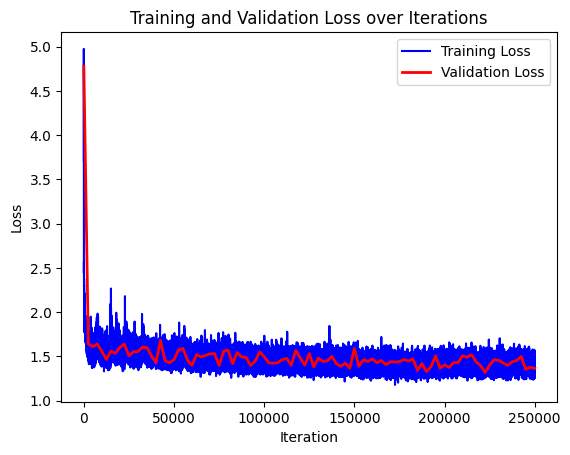

In [18]:
# Plot training and validation loss curves
plt.plot(train_step_history, train_loss_history, "-",label='Training Loss', color='blue')
plt.plot(val_step_history, val_loss_history, "-", label='Validation Loss', lw = 2, color='red')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss over Iterations")
plt.legend()
plt.savefig(cwd / "loss_curve.png")
plt.show()

## Testing the model on a given prompt

We finally test the trained model by generating text based on a given prompt. The model successfully generates a sequence of characters that continue from the prompt, and we save the generated text to a file for review.

In [19]:
# Test the model on a given prompt
prompt = "the meaning of life is"
encoded_prompt = fn.encode(prompt, chars_to_int)
context = encoded_prompt[None, :]

B = 1
seed = seed
generate_len = 1000
rng = jax.random.PRNGKey(seed)

output_indices = fn.generate_tokens(
    model=model_obj,
    params=params,
    constants=constants,
    rng=rng,
    context=context,
    length=generate_len,
    block_size=64,
    temperature=0.8,
    sample=True,
    pad_id=None,
    deterministic=True
)

output_indices = np.array(output_indices)  # Convert from JAX array to NumPy array
generated_text = fn.decode(output_indices, int_to_chars)

print("Generated ID Shape:", output_indices.shape)
print("Generated Text:")
print(prompt + generated_text)

generated_text_file = cwd / "generated_text.txt"

with open(generated_text_file, "w") as f:
    f.write(prompt + generated_text)

Generated ID Shape: (1, 1000)
Generated Text:
the meaning of life is there are power than not on the day general million actor accomplished a coounter of he was down to countries from the regions to known as a sum navigable in honor it fellow office case the new in the world like matersak of earlier aplay considered context afterward of the motors the two exist rules and all to the two and one one three throughout i it water produced careers are design the exhibitor in an additional for a security of the also a depict to the permitted by lee power collection such as software with the battles love nine and underw is now comment marine robert head the each of consist see also here example this essential heart with the next resource a constitution of a period of glory phenomenon the last where invention for his is productions and of center and entitled during out the and the ternal the schools before however he catholic or many include dike to distribute of a them commonly want an indian 